<a href="https://colab.research.google.com/github/darioka/impactdeal-2022/blob/main/notebooks/EPC_02_decision_tree_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/darioka/impactdeal-2022.git
%cd impactdeal-2022
!pip install -r requirements.txt
!pip install .

Cloning into 'impactdeal-2022'...
remote: Enumerating objects: 157, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 157 (delta 2), reused 8 (delta 1), pack-reused 141
Receiving objects: 100% (157/157), 71.29 MiB | 32.78 MiB/s, done.
Resolving deltas: 100% (76/76), done.
/content/impactdeal-2022
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: missingno
    Found existing installation: missingno 0.5.1
    Uninstalling missingno-0.5.1:
      Successfully uninstalled missingno-0.5.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/impactdeal-2022
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it bec

# Decision Trees - EPC Rating

In this notebook you will fit a `DecisionTreeClassifier` on the EPC rating dataset. You will experience for yourself what it means to work with real world data!

## Loading the data

As we did for the exploration, let's load the dataset `known_epc_ratings.csv.gz`. If you remember, there is a column with datetime values. It could be useful to convert it to the correct datetime data type during loading. Take a look at `parse_dates` and `infer_datetime_format` of the `pandas`'s documentation about the `read_csv` command.

In [2]:
# Write your code here!

# ...

# raw_df =

In [3]:
import pandas as pd

raw_df = pd.read_csv("data/known_epc_ratings.csv.gz", parse_dates=["INSPECTION_DATE"], infer_datetime_format=True)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## The problem

We remember from the exploration here we don't have a binary classification problem, but a **multiclass classification**. Fortunately, there will be no difference in how we train a `DecisionTreeClassifier`. There will be some differences though in the way we interpret the performance metrics.

Let's now discuss more deeply about the EPC rating dataset. There is small discrepancy between what we want to do, that is to predict the EPC rating *for each property*, and what the dataset is: a collection of data *for each EPC assessment*. In other words, **the dataset may contain multiple EPC ratings for each property**. There are several reasons why we must take that into account:
1. Older EPC ratings may have been updated and could contain incorrect data.
2. If a property has two EPC ratings, say A and B, what should the model output for that property? A or B?
3. If a property has two EPC ratings, when we split the data, one of the sample could be in the training set and the other in the test set. This may lead to an overestimation of the performance of a model on the test set.

In the following cells, show that there are multiple EPC ratings for the same `BUILDING_REFERENCE_NUMBER`. Then create a new dataframe with only the most recent assessments for each property.

In [4]:
# Write your code here!

# ...

# df =

In [5]:
df = raw_df.sort_values(["BUILDING_REFERENCE_NUMBER", "INSPECTION_DATE"]).drop_duplicates(subset="BUILDING_REFERENCE_NUMBER", keep="last")

In [6]:
raw_df.shape, df.shape

((992766, 42), (766277, 42))

In [7]:
raw_df["INSPECTION_DATE"].dt.year.value_counts().sort_index()

2000         1
2003         1
2004         1
2006         9
2007        21
2008     32372
2009    102255
2010     70380
2011     60665
2012     57198
2013    101946
2014    105282
2015     80993
2016     74688
2017     47795
2018     55599
2019     65925
2020     63946
2021     73689
Name: INSPECTION_DATE, dtype: int64

In [8]:
df["INSPECTION_DATE"].dt.year.value_counts().sort_index()

2003        1
2004        1
2006        4
2007       11
2008    12213
2009    51611
2010    45266
2011    45826
2012    44319
2013    70794
2014    75803
2015    64545
2016    61530
2017    44291
2018    51920
2019    63594
2020    62467
2021    72081
Name: INSPECTION_DATE, dtype: int64

## Cleaning

During exploration we saw that the dataset has some issues with data quality. Some cleaning functions have been provided for your conveniennce. You can find them in the `cleaning` module of the package `impactdeal`.

In [9]:
df.isnull().sum()

CITY                                 0
LMK_KEY                              0
POSTCODE                             0
BUILDING_REFERENCE_NUMBER            0
PROPERTY_TYPE                        0
BUILT_FORM                         611
CONSTRUCTION_AGE_BAND             8910
INSPECTION_DATE                      0
TOTAL_FLOOR_AREA                     0
ENERGY_TARIFF                       26
MAINS_GAS_FLAG                   87776
FLOOR_LEVEL                      50206
FLAT_TOP_STOREY                 521033
FLAT_STOREY_COUNT               719653
MAIN_HEATING_CONTROLS           162994
MULTI_GLAZE_PROPORTION           73690
GLAZED_TYPE                      15880
GLAZED_AREA                      15818
EXTENSION_COUNT                  86123
NUMBER_HABITABLE_ROOMS           86123
NUMBER_HEATED_ROOMS              86123
LOW_ENERGY_LIGHTING              25158
NUMBER_OPEN_FIREPLACES           15329
HOTWATER_DESCRIPTION                 0
FLOOR_DESCRIPTION                   29
WINDOWS_DESCRIPTION      

In [10]:
from impactdeal.config.column_names import TARGET, NUMERICAL, CATEGORICAL
from impactdeal import cleaning

# all missing values in the categorical columns will be replaced with np.nan
df = cleaning.normalize_missing(df, CATEGORICAL)

# specific cleaning steps for some of the features
df = cleaning.clean_age_band(df)
df = cleaning.clean_floor_level(df)
df = cleaning.clean_mainheat(df)

In [11]:
df.isnull().sum()

CITY                                 0
LMK_KEY                              0
POSTCODE                             0
BUILDING_REFERENCE_NUMBER            0
PROPERTY_TYPE                        0
BUILT_FORM                       24679
CONSTRUCTION_AGE_BAND            78992
INSPECTION_DATE                      0
TOTAL_FLOOR_AREA                     0
ENERGY_TARIFF                    86654
MAINS_GAS_FLAG                   87776
FLOOR_LEVEL                     485363
FLAT_TOP_STOREY                 521033
FLAT_STOREY_COUNT               719653
MAIN_HEATING_CONTROLS           163003
MULTI_GLAZE_PROPORTION           73690
GLAZED_TYPE                     112416
GLAZED_AREA                      86123
EXTENSION_COUNT                  86123
NUMBER_HABITABLE_ROOMS           86123
NUMBER_HEATED_ROOMS              86123
LOW_ENERGY_LIGHTING              25158
NUMBER_OPEN_FIREPLACES           15329
HOTWATER_DESCRIPTION              1363
FLOOR_DESCRIPTION                  671
WINDOWS_DESCRIPTION      

## Preprocessing

Here we start we the preprocessing steps that will lead us to model training.

### Train-test split

First of all, let's define `X` as a dataframe with the features we want to use, namely `NUMERICAL` and `CATEGORICAL`, and `y` as the series with the `TARGET`.

Then split `X` and `y` in train (70%) and test (30%), stratifying on `y`.

In [12]:
# Write your code here!

# ...

# X = 
# y = 

# X_train, X_test, y_train, y_test =

In [13]:
from sklearn.model_selection import train_test_split

X = df[NUMERICAL + CATEGORICAL]
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

### Dropping columns

As we saw during exploration, some of the features we have hardly convey information. This is the case with columns that mostly contain missing data. Additionally, we noticed that there are multiple variables with information about lighting in the property, that they are correlated and some of them have many missing values.

For simplicity, let's also discard all textual columns (the ones whose name ends with `DESCRIPTION`). Being free text, if we treat them as simple categories we could have a huge amount of classes. This is not helpful for any model. There are are methods to treat text, that we will see in future modules.

In [14]:
# Write your code here!

# ...

# numerical_cols = [...]
# categorical_cols = [...]

# X_train = 
# X_test = 

In [15]:
columns_to_drop = [i for i, x in df.isnull().mean().iteritems() if x > 0.7]
columns_to_drop += ["LOW_ENERGY_FIXED_LIGHT_COUNT"]
columns_to_drop += [x for x in df.columns if x.lower().endswith("description")]
print(f"Dropped columns: {columns_to_drop}")

categorical_cols = [x for x in CATEGORICAL if x not in columns_to_drop]
numerical_cols = [x for x in NUMERICAL if x not in columns_to_drop]

X_train = X_train[numerical_cols + categorical_cols]
X_test = X_test[numerical_cols + categorical_cols]

Dropped columns: ['FLAT_STOREY_COUNT', 'HEAT_LOSS_CORRIDOR', 'UNHEATED_CORRIDOR_LENGTH', 'LOW_ENERGY_FIXED_LIGHT_COUNT', 'HOTWATER_DESCRIPTION', 'FLOOR_DESCRIPTION', 'WINDOWS_DESCRIPTION', 'WALLS_DESCRIPTION', 'SECONDHEAT_DESCRIPTION', 'ROOF_DESCRIPTION', 'MAINHEAT_DESCRIPTION', 'MAINHEATCONT_DESCRIPTION', 'LIGHTING_DESCRIPTION']


### Missing values

In this dataset, missing values can be found both in numerical and categorical columns. We saw that a good way to encode missing values for categorical columns is to treat them as another category. For numerical values instead our solution will be [imputation](https://en.wikipedia.org/wiki/Imputation_(statistics)).

A common imputation method is mean imputation, where one replaces missing data in a column with the mean value of that column. This is an assumption, of course, and sometimes better assumptions could be made trying to understand the data collection process.

In our case, for example, if `MULTI_GLAZE_PROPORTION` is null it seems reasonable to think that the property has no multiple glazing, which would be equivalent to set `MULTI_GLAZE_PROPORTION=0`. This could be a more conservative assumption compared to the mean.

In the following cells, decide for which features it would be better to use a constant value imputation and for which ones a mean imputation. Then apply the transformations using `scikit-lean` [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html).

In [16]:
# Write your code here!

# ...

# zero_imputed_cols = [...]
# mean_imputed_cols = [...]

# ...

# X_train[zero_imputed_cols] = 
# X_train[mean_imputed_cols] = 
# X_test[zero_imputed_cols] = 
# X_test[mean_imputed_cols] = 

# ...

In [17]:
from sklearn.impute import SimpleImputer

zero_imputed_cols = [
    "MULTI_GLAZE_PROPORTION",
    "EXTENSION_COUNT",
    "LOW_ENERGY_LIGHTING",
    "NUMBER_OPEN_FIREPLACES",
    "WIND_TURBINE_COUNT"
]
mean_imputed_cols = ["NUMBER_HABITABLE_ROOMS", "NUMBER_HEATED_ROOMS", "FLOOR_HEIGHT", "FIXED_LIGHTING_OUTLETS_COUNT"]

zero_imputer = SimpleImputer(strategy="constant", fill_value=0)
mean_imputer = SimpleImputer(strategy="mean")

X_train[zero_imputed_cols] = zero_imputer.fit_transform(X_train[zero_imputed_cols])
X_test[zero_imputed_cols] = zero_imputer.transform(X_test[zero_imputed_cols])

X_train[mean_imputed_cols] = zero_imputer.fit_transform(X_train[mean_imputed_cols])
X_test[mean_imputed_cols] = zero_imputer.transform(X_test[mean_imputed_cols])

### Categorical encoding

Now we will encode categorical variables. However...

One problem with categorical variables in real world datasets is rare classes, for several reasons:
1. Why are there so few samples with those classes? Instead of valid classes, they could be just errors in the data collection process.
2. If only few samples belongs to a category, every machine learning model will struggle to learn anything from them. Having many rare classes is never beneficial for models.
3. Having many rare classes does not help interpretation.
4. If there are very few examples with a certain class, they might end up in just one of the train o test dataset.

For these reasons, before the `OrdinalEncoder` we will add one more preprocessing step that converts rare classes to another constant value, for example `"other"` or `np.nan`.

Read the docstring of the object `impactdeal.CategoryReducer`, then use it followed by `OrdinalEncoder` to encode all categorical columns in our dataset.

In [18]:
# Write your code here!

# ...

# X_train[categorical_cols] = 
# X_test[categorical_cols] = 

# ...

In [19]:
from impactdeal.preprocessing import CategoryReducer
from sklearn.preprocessing import OrdinalEncoder

reducer = CategoryReducer(size=50)
encoder = OrdinalEncoder()

X_train[categorical_cols] = reducer.fit_transform(X_train[categorical_cols])
X_test[categorical_cols] = reducer.transform(X_test[categorical_cols])

X_train[categorical_cols] = encoder.fit_transform(X_train[categorical_cols].astype(str))
X_test[categorical_cols] = encoder.transform(X_test[categorical_cols].astype(str))

In [20]:
encoder.categories_

[array(['Birmingham', 'Leeds', 'Manchester'], dtype=object),
 array(['Bungalow', 'Flat', 'House', 'Maisonette', 'nan'], dtype=object),
 array(['Detached', 'Enclosed End-Terrace', 'Enclosed Mid-Terrace',
        'End-Terrace', 'Mid-Terrace', 'Semi-Detached', 'nan'], dtype=object),
 array(['1899 and earlier', '1900-1929', '1930-1949', '1950-1966',
        '1967-1975', '1976-1982', '1983-1990', '1991-1995', '1996-2002',
        '2003-2006', '2007 onwards', 'nan'], dtype=object),
 array(['24 hour', 'Single', 'dual', 'dual (24 hour)', 'nan',
        'off-peak 10 hour', 'off-peak 7 hour', 'standard tariff'],
       dtype=object),
 array(['N', 'Y', 'nan'], dtype=object),
 array(['0', '10th', '11st', '12nd', '13rd', '14th', '15th', '16th',
        '17th', '18th', '19th', '1st', '20th', '2nd', '3rd', '4th', '5th',
        '6th', '7th', '8th', '9th', 'above 20th', 'basement', 'mid floor',
        'nan', 'top floor'], dtype=object),
 array(['N', 'Y', 'nan'], dtype=object),
 array(['2101', '2102',

In [21]:
X_train.isnull().sum()

TOTAL_FLOOR_AREA                0
MULTI_GLAZE_PROPORTION          0
EXTENSION_COUNT                 0
NUMBER_HABITABLE_ROOMS          0
NUMBER_HEATED_ROOMS             0
LOW_ENERGY_LIGHTING             0
NUMBER_OPEN_FIREPLACES          0
WIND_TURBINE_COUNT              0
FLOOR_HEIGHT                    0
FIXED_LIGHTING_OUTLETS_COUNT    0
CITY                            0
PROPERTY_TYPE                   0
BUILT_FORM                      0
CONSTRUCTION_AGE_BAND           0
ENERGY_TARIFF                   0
MAINS_GAS_FLAG                  0
FLOOR_LEVEL                     0
FLAT_TOP_STOREY                 0
MAIN_HEATING_CONTROLS           0
GLAZED_TYPE                     0
GLAZED_AREA                     0
MAIN_FUEL                       0
SOLAR_WATER_HEATING_FLAG        0
MECHANICAL_VENTILATION          0
dtype: int64

## Model training

Finally, we can now train our decision tree. In the following cell, fit a `DecisionTreeClassifier`, then score the model on the test set the visualize the predictions with a confusion matrix.

In [22]:
# Write your code here!



In [23]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay


model = DecisionTreeClassifier(max_depth=15)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=15)

## Model evaluation

Now compute the classification performances of the model both on the train and the test sets.

              precision    recall  f1-score   support

           A       0.87      0.24      0.38       690
           B       0.86      0.83      0.85     55520
           C       0.75      0.70      0.72    162440
           D       0.65      0.79      0.72    211341
           E       0.64      0.47      0.54     87370
           F       0.69      0.41      0.51     14668
           G       0.83      0.64      0.72      4364

    accuracy                           0.70    536393
   macro avg       0.76      0.58      0.63    536393
weighted avg       0.71      0.70      0.70    536393



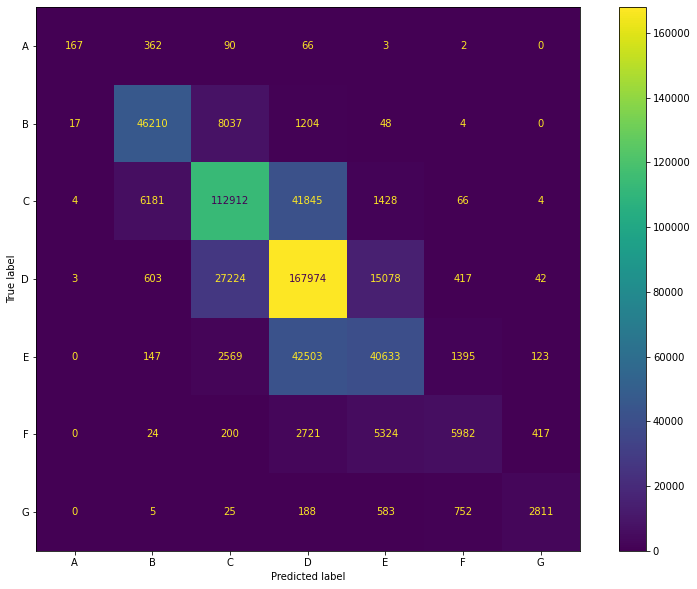

In [24]:
fig, ax = plt.subplots(figsize=(14,10))
ConfusionMatrixDisplay.from_estimator(model, X_train, y_train, ax=ax)

print(classification_report(y_train, model.predict(X_train)))

              precision    recall  f1-score   support

           A       0.70      0.16      0.26       295
           B       0.83      0.81      0.82     23795
           C       0.71      0.66      0.68     69618
           D       0.62      0.75      0.68     90575
           E       0.55      0.39      0.46     37444
           F       0.45      0.27      0.33      6286
           G       0.60      0.46      0.52      1871

    accuracy                           0.65    229884
   macro avg       0.64      0.50      0.54    229884
weighted avg       0.65      0.65      0.65    229884



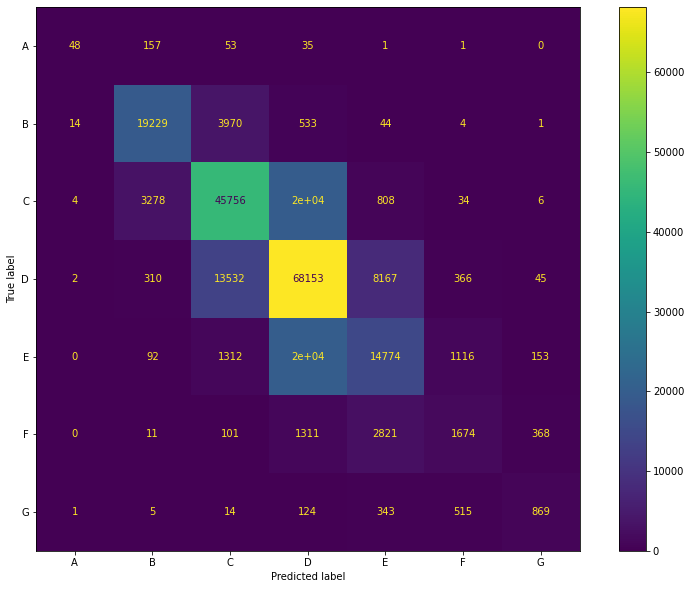

In [25]:
fig, ax = plt.subplots(figsize=(14,10))
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=ax)

print(classification_report(y_test, model.predict(X_test)))

Finally, let's try to understand deeper implications of this model. For example:

* Is the model equally good on old building as well as new buildings?
* Are model performances similar in the three cities?

This is uncharted terrain... try to show, understand, discuss possible reasons why there are differences in the performances of the model.

In [26]:
X_test_pred = X_test.copy()
X_test_pred["prediction"] = model.predict(X_test)
X_test_pred["target"] = y_test
X_test_pred["correct_prediction"] = X_test_pred["target"] == X_test_pred["prediction"]

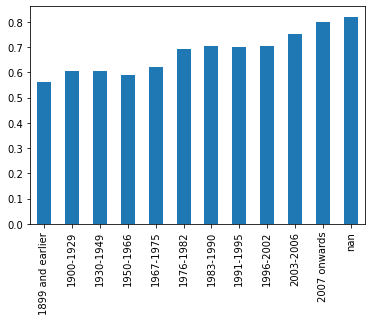

In [27]:
X_test_pred.groupby("CONSTRUCTION_AGE_BAND")["correct_prediction"].mean().set_axis(
    encoder.categories_[encoder.feature_names_in_.tolist().index("CONSTRUCTION_AGE_BAND")]
).plot.bar()

In [28]:
for i, grouped_df in X_test_pred.groupby("CITY"):
    print("================================================")
    print(encoder.categories_[encoder.feature_names_in_.tolist().index("CITY")][int(i)])
    print("------------------------------------------------")
    print(classification_report(grouped_df["target"], grouped_df["prediction"]))

Birmingham
------------------------------------------------
              precision    recall  f1-score   support

           A       0.58      0.16      0.25        93
           B       0.84      0.81      0.83      7969
           C       0.69      0.63      0.66     23987
           D       0.62      0.77      0.68     39002
           E       0.57      0.41      0.48     18932
           F       0.44      0.23      0.30      3220
           G       0.65      0.49      0.56       943

    accuracy                           0.64     94146
   macro avg       0.63      0.50      0.54     94146
weighted avg       0.64      0.64      0.63     94146

Leeds
------------------------------------------------
              precision    recall  f1-score   support

           A       0.77      0.13      0.22       154
           B       0.82      0.80      0.81      7333
           C       0.70      0.63      0.66     23010
           D       0.63      0.76      0.69     31371
           E     

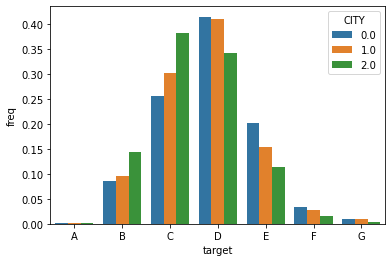

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

_ = sns.barplot(
    data=X_test_pred.groupby("CITY")["target"].value_counts(normalize=True).rename("freq").reset_index().sort_values(["CITY", "target"]),
    x="target",
    hue="CITY",
    y="freq")
plt.show()